# Trabajo Práctico Final Visión Por computadora
Facultad de Ciencias Exactas, Ingenieria y Agrimensura - TUIA
- Pace, Bruno Emmanuel. P-5295/7.

# Preparación del entorno
- Instalación de librerías
- Función para descargar data y modelos para reducir tiempo de ejecución



In [1]:
# modificar si así se quiere
descargar_data = True

In [43]:
# 📦 Instalación de dependencias
!pip install faiss-cpu --quiet
!pip install onnx onnxruntime --quiet
# !pip install albumentations --quiet
# !pip install gradio --quiet

# 📁 Descarga de documentos desde Google Drive
import gdown

# ⚙️ Librerías estándar
import os
import time
import glob
import json
import shutil
import random
import datetime
from pathlib import Path
from collections import Counter

# 📊 Progreso y visualización
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 🧮 Procesamiento de datos
import numpy as np
import pandas as pd

# 🖼️ Procesamiento de imágenes
import cv2
from PIL import Image
from torchvision import transforms

# 🤖 Frameworks de Deep Learning
import torch
import torch.onnx as onnx
import torchvision
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models import ResNet18_Weights
from torchvision.datasets import ImageFolder

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras.utils import img_to_array, load_img as keras_image

# 🧠 ONNX
import onnxruntime as ort

# 🔍 Bases de datos vectoriales
import faiss

# 🧪 COCO - Evaluación
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# 🎨 Aumentación de datos
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 🌐 Interfaz web
import gradio as gr

# 🧪 Métricas
from sklearn.metrics import ndcg_score

import matplotlib.pyplot as plt


# ✅ Verificación de versiones
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")


PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0


In [3]:
def download_data(flag:bool = True) -> None:
  folder_id = '140YimxDX7EqSgPS1S_gpWF8mWVfEPSld'
  output_directory = '/content'
  if flag:
    try:
      gdown.download_folder(id=folder_id, output=output_directory, quiet=False, use_cookies=False)
      print(f"Data descargada en'{output_directory}'.")
    except Exception as e:
      print(f"No se pudo descargar. Error: {e}")

download_data(descargar_data)

Retrieving folder contents


Retrieving folder 1NcmjLoScNAZlkBTONzxeLoeej4Lii0tr imagenes_complejas
Processing file 1PFjmPEQd9qBnefD07EdMmXPRtI3Bt-6g perro1.jpg
Processing file 1s5u3UzDP-jhCC-eMjtJIPPsfK_GNo2Ca perro2.png
Processing file 1MO0CaDBwE9BtL3LufIBf9C0MEM1tDpnC perro3.png
Processing file 1X8LJ_lMCt0SXhTEmDMsM8MqVbkxAwC4f perro4.png
Processing file 1SrPjFf71XXrZRW9pH6bTviSU-AHR49ju perro5.png
Processing file 1-Mz5So63nURzTZ2ydupaVj-G7lKrfDtf perro6.png
Processing file 1TO6UK0gNdCiCqzBCykU57JjC2NnjKctF perro7.png
Processing file 1Rdzy62bB5P566CPRCWGRnjmIg7N_u1pF perro8.png
Processing file 1sDe1Hf40TIF798MPMvAiNiXdDIz5gbJn perro9.png
Processing file 1wUFEVMD2paw9LvZDV_2amBNbloLivYBU perro10.png
Processing file 1lRTKJHkviriIzXFMmSqEnnHft1KTONND custom_model.keras
Processing file 1TTCCTzZatX9PNqe3M6iMyhYL9D-uPbnn dog_breed_classifier.pth
Processing file 19bkbg1FfYgheockush3tjk5m9VYdi1c5 dog_embeddings_resnet50.npz
Processing file 1jcoY6ZXrqiYGz92kvzsZtSzAfXv8eekX instances_default.json
Processing file 13y-XnE

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1PFjmPEQd9qBnefD07EdMmXPRtI3Bt-6g
To: /content/imagenes_complejas/perro1.jpg
100%|██████████| 146k/146k [00:00<00:00, 10.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1s5u3UzDP-jhCC-eMjtJIPPsfK_GNo2Ca
To: /content/imagenes_complejas/perro2.png
100%|██████████| 248k/248k [00:00<00:00, 5.82MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MO0CaDBwE9BtL3LufIBf9C0MEM1tDpnC
To: /content/imagenes_complejas/perro3.png
100%|██████████| 273k/273k [00:00<00:00, 5.32MB/s]
Downloading...
From: https://drive.google.com/uc?id=1X8LJ_lMCt0SXhTEmDMsM8MqVbkxAwC4f
To: /content/imagenes_complejas/perro4.png
100%|██████████| 229k/229k [00:00<00:00, 15.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SrPjFf71XXrZRW9pH6bTviSU-AHR49ju
To: /content/imagenes_complejas/perro5.png
100%|██████████| 1.02M/1.02M [00:00<00:00, 24.

Data descargada en'/content'.



Download completed


# Descarga del dataset

In [4]:
import kagglehub
dataset_path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", dataset_path)

df = pd.read_csv(os.path.join(dataset_path,"dogs.csv"))

Path to dataset files: /kaggle/input/70-dog-breedsimage-data-set


In [5]:
df.sample(10)

,filepaths,labels,data set
5131,train/Komondor/001.jpg,Komondor,train
7694,train/Shih-Tzu/185.jpg,Shih-Tzu,train
71,train/Afghan/072.jpg,Afghan,train
3203,train/Collie/040.jpg,Collie,train
1488,train/Bluetick/048.jpg,Bluetick,train
7150,train/Schnauzer/096.jpg,Schnauzer,train
8100,test/Borzoi/05.jpg,Borzoi,test
6417,train/Pomeranian/078.jpg,Pomeranian,train
3702,train/Dingo/019.jpg,Dingo,train
6502,train/Poodle/014.jpg,Poodle,train


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  9346 non-null   object
 1   labels     9346 non-null   object
 2   data set   9346 non-null   object
dtypes: object(3)
memory usage: 219.2+ KB


In [7]:
# se normalizan los títulos de las raza porque me aparecían demás.
df["labels"] = df["labels"].str.strip()
df["labels"] = df["labels"].str.replace(r"\s+", " ", regex=True)  # Normaliza espacios múltiples
df["labels"] = df["labels"].str.title()  # Estandariza mayúsculas
clases = df["labels"].unique()
print(sorted(clases))

['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


chequeo de cantidad de clases

In [8]:
class_number: int = len(df['labels'].unique())
print(f'cantidad de clases: {class_number}')

cantidad de clases: 70


# Etapa 1

## EDA

In [9]:
dataset_path_train = os.path.join(dataset_path, "train")

In [10]:
# Obtener lista de clases (subdirectorios en la carpeta de entrenamiento)
clases = [d for d in os.listdir(dataset_path_train)
          if os.path.isdir(os.path.join(dataset_path_train, d))]

# Contar imágenes por clase
conteo = []
for clase in clases:
    directorio_clase = os.path.join(dataset_path_train, clase)
    # Contar solo archivos de imagen
    archivos_imagen = [f for f in os.listdir(directorio_clase)
                      if os.path.isfile(os.path.join(directorio_clase, f)) and
                      f.lower().endswith(('.jpg'))]

    conteo.append({
        "Clase": clase,
        "Cantidad": len(archivos_imagen)
    })

# Crear DataFrame
df_clases = pd.DataFrame(conteo).sort_values(by="Cantidad", ascending=False)

# Calcular estadísticas
q1 = df_clases['Cantidad'].quantile(0.25)
mediana = df_clases['Cantidad'].quantile(0.5)
media = df_clases['Cantidad'].mean()
q2 = df_clases['Cantidad'].quantile(0.5)
q3 = df_clases['Cantidad'].quantile(0.75)

print(f"\nEstadísticas del conjunto de datos:")
print(f"Total de clases: {len(df_clases)}")
print(f"Q1 (percentil 25%): {q1:.0f} imágenes por clase")
print(f"Q2 (percentil 50%: {q2:.0f} imágenes por clase)")
print(f"Mediana: {mediana:.0f} imágenes por clase")
print(f"Media: {media:.0f} imágenes por clase")
print(f"Q3 (percentil 75%): {q3:.0f} imágenes por clase")
print(f"Máximo: {df_clases['Cantidad'].max():.0f} imágenes en una clase")
print(f"Mínimo: {df_clases['Cantidad'].min():.0f} imágenes en una clase")

# Visualización con Plotly
fig = px.bar(
    df_clases,
    x='Clase',
    y='Cantidad',
    title='Cantidad de imágenes por raza de perro (clase)',
    text='Cantidad',
    color='Clase',
    labels={
        'Clase': 'Raza de perro',
        'Cantidad': 'Número de imágenes'
    }
)
fig.update_traces(
    textposition='outside',
    textfont_size=12
)
fig.update_layout(
    showlegend=False,
    xaxis_title='Raza de perro',
    yaxis_title='Cantidad de imágenes',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    xaxis={'categoryorder':'total descending'}
)
fig.show()


Estadísticas del conjunto de datos:
Total de clases: 70
Q1 (percentil 25%): 99 imágenes por clase
Q2 (percentil 50%: 112 imágenes por clase)
Mediana: 112 imágenes por clase
Media: 114 imágenes por clase
Q3 (percentil 75%): 125 imágenes por clase
Máximo: 198 imágenes en una clase
Mínimo: 65 imágenes en una clase


Se puede observar un claro desbalance con clases que tienen menos ejemplos.

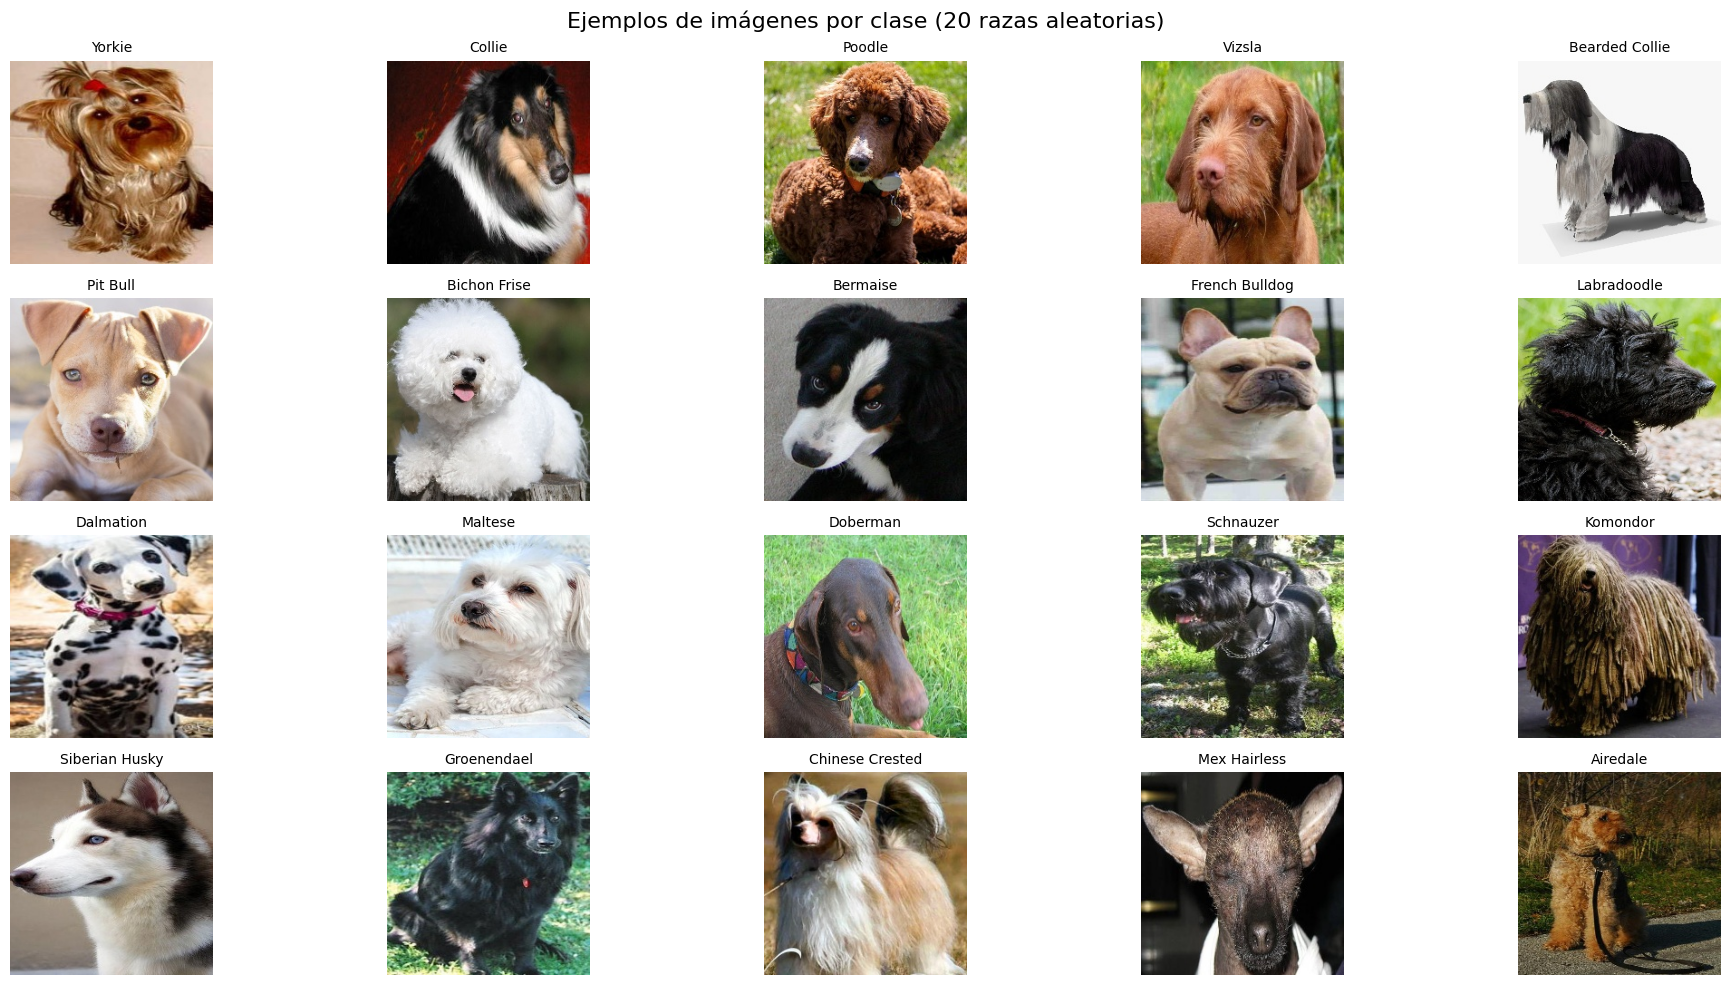


Tamaño promedio de las imágenes (entrenamiento): (224, 224) (ancho x alto)


In [11]:
clases_seleccionadas = random.sample(clases, 20) # Tomar 20 clases al azar

# Obtener una imagen por cada clase seleccionada
imagenes_muestra = []
for clase in clases_seleccionadas:
    clase_dir = os.path.join(dataset_path_train, clase)
    archivos = [f for f in os.listdir(clase_dir)
               if f.lower().endswith(('.jpg'))]
    if archivos:  # Asegurarse que hay imágenes
        imagen_ejemplo = random.choice(archivos)
        imagenes_muestra.append((clase, os.path.join(clase_dir, imagen_ejemplo)))

plt.figure(figsize=(20, 10))
for i, (clase, path_img) in enumerate(imagenes_muestra):
    img = Image.open(path_img)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(clase, fontsize=10)
    plt.axis("off")
plt.suptitle("Ejemplos de imágenes por clase (20 razas aleatorias)", fontsize=16)
plt.tight_layout()
plt.show()

tamaños = []
for _ in range(100):
    clase_aleatoria = random.choice(clases)
    clase_dir = os.path.join(dataset_path_train, clase_aleatoria)
    archivos = [f for f in os.listdir(clase_dir)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if archivos:
        img_path = os.path.join(clase_dir, random.choice(archivos))
        with Image.open(img_path) as img:
            tamaños.append(img.size)

anchos, altos = zip(*tamaños)
tamaño_promedio = (sum(anchos) // len(anchos), sum(altos) // len(altos))
print(f"\nTamaño promedio de las imágenes (entrenamiento): {tamaño_promedio} (ancho x alto)")

### Balanceo del Dataset

Dado el desbalance del dataset, se opta por aplicar un balanceo simple. Se aumentarán las clases minoritarias.

In [12]:
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.ToPILImage()
])

target_count_per_class = int(q2)

max_count_per_class = q3

print(f"Objetivo de imágenes por clase (mínimo): {target_count_per_class}")
print(f"Máximo de imágenes por clase para undersampling: {max_count_per_class}")

balanced_train_data_path = "/kaggle/working/train_balanced"
os.makedirs(balanced_train_data_path, exist_ok=True)


for index, row in df_clases.iterrows():
    class_name = row['Clase']
    current_count = row['Cantidad']

    original_class_dir = os.path.join(dataset_path_train, class_name)
    balanced_class_dir = os.path.join(balanced_train_data_path, class_name)
    os.makedirs(balanced_class_dir, exist_ok=True)

    images = [f for f in os.listdir(original_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Oversampling
    if current_count < target_count_per_class:
        images_to_generate = target_count_per_class - current_count
        print(f"[{class_name}] Minoria: Generando {images_to_generate} imágenes (de {current_count} a {target_count_per_class}).")

        for img_name in images:
            shutil.copy(os.path.join(original_class_dir, img_name), balanced_class_dir)
         # Generación de aumentación
        original_images_for_augmentation = [Image.open(os.path.join(original_class_dir, img_name)).convert("RGB") for img_name in images]

        generated_count = 0
        while generated_count < images_to_generate:
            for original_img in original_images_for_augmentation:
                if generated_count >= images_to_generate:
                    break
                augmented_img = augmentation_transform(original_img)

                augmented_img.save(os.path.join(balanced_class_dir, f"aug_{class_name}_{generated_count}_{random.randint(0, 10000)}.jpg"))
                generated_count += 1

    # Undersampling
    elif current_count > max_count_per_class:
        print(f"[{class_name}] Mayoria: Recortando imágenes (de {current_count} a {max_count_per_class}).")
        random.shuffle(images)
        for i in range(int(min(len(images), max_count_per_class))):
            shutil.copy(os.path.join(original_class_dir, images[i]), balanced_class_dir)

    # si está dentro del rango aceptado, sólo copia
    else:
        print(f"[{class_name}] Balanceado: Copiando {current_count} imágenes originales.")
        for img_name in images:
            shutil.copy(os.path.join(original_class_dir, img_name), balanced_class_dir)


print(f"\nDataset de entrenamiento balanceado creado en: {balanced_train_data_path}")

# print("\nConteo de clases después del balanceo:")
# new_class_counts = {}
# for class_name in os.listdir(balanced_train_data_path):
#     class_dir = os.path.join(balanced_train_data_path, class_name)
#     if os.path.isdir(class_dir):
#         new_class_counts[class_name] = len(os.listdir(class_dir))

# print(f'clases luego del balance {len(os.listdir(balanced_train_data_path))}')
# for cls, count in sorted(new_class_counts.items(), key=lambda item: item[1]):
#     print(f"- {cls}: {count} imágenes")

Objetivo de imágenes por clase (mínimo): 111
Máximo de imágenes por clase para undersampling: 125.0
[Shih-Tzu] Mayoria: Recortando imágenes (de 198 a 125.0).
[Lhasa] Mayoria: Recortando imágenes (de 187 a 125.0).
[Labrador] Mayoria: Recortando imágenes (de 161 a 125.0).
[Basset] Mayoria: Recortando imágenes (de 159 a 125.0).
[Scotch Terrier] Mayoria: Recortando imágenes (de 150 a 125.0).
[Pomeranian] Mayoria: Recortando imágenes (de 149 a 125.0).
[Pug] Mayoria: Recortando imágenes (de 148 a 125.0).
[Bloodhound] Mayoria: Recortando imágenes (de 147 a 125.0).
[Boxer] Mayoria: Recortando imágenes (de 134 a 125.0).
[Bermaise] Mayoria: Recortando imágenes (de 131 a 125.0).
[Pit Bull] Mayoria: Recortando imágenes (de 130 a 125.0).
[Cocker] Mayoria: Recortando imágenes (de 130 a 125.0).
[Cockapoo] Mayoria: Recortando imágenes (de 129 a 125.0).
[Dingo] Mayoria: Recortando imágenes (de 129 a 125.0).
[Maltese] Mayoria: Recortando imágenes (de 129 a 125.0).
[Bull Mastiff] Mayoria: Recortando imág

## Embeddings

In [13]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
keras_embedding_model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D()
])

def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

if not os.path.exists("dog_embeddings_resnet50.npz"):
    embeddings = []
    labels = []
    filepaths = []

    # Walk through the directory structure
    for class_name in tqdm(os.listdir(balanced_train_data_path), desc="Processing classes"):
        class_dir = os.path.join(balanced_train_data_path, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith('.jpg'):
                    try:
                        full_img_path = os.path.join(class_dir, img_file)
                        img_array = load_and_preprocess_image(full_img_path)
                        embedding = keras_embedding_model.predict(img_array, verbose=0)

                        embeddings.append(embedding.flatten())
                        labels.append(class_name)
                        # Store relative path from dataset root
                        filepaths.append(os.path.join('train', class_name, img_file))
                    except Exception as e:
                        print(f"Error processing {img_file}: {e}")

    # Convert to numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    filepaths = np.array(filepaths)

    # Save embeddings
    np.savez("dog_embeddings_resnet50.npz",
             embeddings=embeddings,
             labels=labels,
             filepaths=filepaths)
    print("Embeddings saved to dog_embeddings_resnet50.npz")
else:
    # Load existing embeddings
    data = np.load("dog_embeddings_resnet50.npz", allow_pickle=True)
    embeddings = data["embeddings"]
    labels = data["labels"]
    filepaths = data["filepaths"]
    print("Embeddings loaded from dog_embeddings_resnet50.npz")
    print(f"Total embeddings loaded: {len(embeddings)}")

Embeddings loaded from dog_embeddings_resnet50.npz
Total embeddings loaded: 8956


### Base de Datos Vectorial

In [14]:
# Normalizar embeddings
faiss.normalize_L2(embeddings)

# Crear el índice FAISS: utiliza L2 con vectores normalizados ≈ coseno
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(embeddings)

print(f"Índice FAISS creado con {index.ntotal} vectores.")

Índice FAISS creado con 8956 vectores.


In [15]:
# def get_embedding(img: Image.Image):
#     img = img.convert("RGB").resize((224, 224))
#     x = keras_image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
#     embedding = keras_embedding_model.predict(x, verbose=0)
#     embedding = embedding.flatten().reshape(1, -1).astype(np.float32)
#     faiss.normalize_L2(embedding)
#     return embedding

# def buscar_similares(img: Image.Image):
#     query_embedding = get_embedding(img)
#     D, I = index.search(query_embedding, k=10)

#     resultados = []
#     razas = []

#     for idx in I[0]:
#         path_img = os.path.join(dataset_path, filepaths[idx])
#         raza = labels[idx]
#         resultados.append(Image.open(path_img).resize((224, 224)))
#         razas.append(raza)

#     # Voto mayoritario
#     pred_raza = Counter(razas).most_common(1)[0][0]

#     return resultados, pred_raza

In [16]:
def get_embedding(img: Image.Image):
    """Genera un embedding para la imagen usando ResNet50."""
    try:
        # Convertir a RGB si no lo está
        img = img.convert("RGB")

        # Redimensionar y preprocesar
        img = img.resize((224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Generar embedding
        embedding = keras_embedding_model.predict(x, verbose=0)
        embedding = embedding.flatten().reshape(1, -1).astype('float32')

        # Normalizar para FAISS
        faiss.normalize_L2(embedding)
        return embedding
    except Exception as e:
        print(f"Error en get_embedding: {str(e)}")
        return None

def buscar_similares(img: Image.Image):
    """Busca imágenes similares en el dataset usando embeddings."""
    try:
        query_embedding = get_embedding(img)
        if query_embedding is None:
            return [], "Error al generar embedding"

        # Buscar los 10 vecinos más cercanos
        D, I = index.search(query_embedding, k=10)

        resultados = []
        razas = []

        for idx in I[0]:
            try:
                # Usar rutas relativas para acceder a las imágenes
                rel_path = filepaths[idx]
                full_path = os.path.join(dataset_path, rel_path)

                if not os.path.exists(full_path):
                    print(f"Advertencia: No se encontró {full_path}")
                    continue

                img = Image.open(full_path).convert("RGB").resize((224, 224))
                resultados.append(img)
                razas.append(labels[idx])
            except Exception as e:
                print(f"Error cargando imagen {filepaths[idx]}: {str(e)}")
                continue

        if not razas:
            return [], "No se encontraron imágenes similares"

        # Predicción por voto mayoritario
        pred_raza = Counter(razas).most_common(1)[0][0]

        return resultados, f"Raza estimada: {pred_raza}"

    except Exception as e:
        print(f"Error en buscar_similares: {str(e)}")
        return [], f"Error al buscar imágenes similares: {str(e)}"

No se ejecuta porque se habló en consulta no hacer tantas interfaces.

In [17]:
# # Interfaz Gradio
# def interfaz_gradio(img):
#     imagenes, pred_raza = buscar_similares(img)
#     return imagenes, f"Raza estimada: {pred_raza}"

# gr.Interface(
#     fn=interfaz_gradio,
#     inputs=gr.Image(type="pil"),
#     outputs=[
#         gr.Gallery(label="Imágenes Similares", columns=5, height="auto"),
#         gr.Textbox(label="Predicción")
#     ],
#     title="Buscador de Razas de Perros por Similitud",
#     description="Subí una imagen de un perro y encuentra las 10 más similares del dataset."
# ).launch()

# Etapa 2

In [21]:
resnet18_model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

resnet18_model.fc = torch.nn.Linear(resnet18_model.fc.in_features, class_number)

# Check if GPU (CUDA) is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [22]:
# transformación para todas las imagenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar los datasets

val_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

train_dataset = ImageFolder(balanced_train_data_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_model.fc.parameters(), lr=0.01, momentum=0.9)
pytorch_classifier_model = resnet18_model.to(device)

In [24]:
def train(model_to_train, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    model_to_train = model_to_train.to(device)

    # Inicializar las métricas como atributos del modelo
    model_to_train.train_metrics = {'loss': [], 'acc': []}
    model_to_train.val_metrics = {'loss': [], 'acc': []}

    for epoch in range(num_epochs):
        model_to_train.train()
        running_loss = 0.0
        running_corrects = 0

        # Fase de entrenamiento
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model_to_train(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calcular métricas de entrenamiento
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.float() / len(train_loader.dataset)
        model_to_train.train_metrics['loss'].append(epoch_train_loss)
        model_to_train.train_metrics['acc'].append(epoch_train_acc.item())

        # Fase de validación
        model_to_train.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model_to_train(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        # Calcular métricas de validación
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_corrects.float() / len(val_loader.dataset)
        model_to_train.val_metrics['loss'].append(epoch_val_loss)
        model_to_train.val_metrics['acc'].append(epoch_val_acc.item())

        # Mostrar progreso
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}')

    # Guardar el modelo completo (no solo state_dict) para preservar las métricas
    torch.save({
        'model_state_dict': model_to_train.state_dict(),
        'train_metrics': model_to_train.train_metrics,
        'val_metrics': model_to_train.val_metrics
    }, 'dog_breed_classifier.pth')

In [25]:
# Cargar o entrenar el modelo
if os.path.exists('dog_breed_classifier.pth'):
    # Add map_location=torch.device('cpu') to load onto CPU
    if torch.cuda.is_available():
        checkpoint = torch.load('dog_breed_classifier.pth', map_location=torch.device('cuda'))
    else:
      checkpoint = torch.load('dog_breed_classifier.pth', map_location=torch.device('cpu'))
    pytorch_classifier_model.load_state_dict(checkpoint['model_state_dict'])

    # Restaurar las métricas
    pytorch_classifier_model.train_metrics = checkpoint['train_metrics']
    pytorch_classifier_model.val_metrics = checkpoint['val_metrics']

    print("Modelo cargado desde dog_breed_classifier.pth")
    print("\nMétricas guardadas en el modelo:")
    print("Última epoch de entrenamiento:")
    print(f"Train loss: {pytorch_classifier_model.train_metrics['loss'][-1]:.4f}")
    print(f"Train accuracy: {pytorch_classifier_model.train_metrics['acc'][-1]:.4f}")
    print(f"Val loss: {pytorch_classifier_model.val_metrics['loss'][-1]:.4f}")
    print(f"Val accuracy: {pytorch_classifier_model.val_metrics['acc'][-1]:.4f}")
else:
    train(pytorch_classifier_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Modelo cargado desde dog_breed_classifier.pth

Métricas guardadas en el modelo:
Última epoch de entrenamiento:
Train loss: 0.1475
Train accuracy: 0.9591
Val loss: 0.6476
Val accuracy: 0.9157


## Modelo custom

In [26]:
def crear_modelo_personalizado(num_clases=70, input_shape=(224, 224, 3)):
    """Modelo CNN personalizado para clasificación de razas de perros"""
    inputs = layers.Input(shape=input_shape)

    # Bloques convolucionales
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    # Capas fully connected
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_clases, activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)


# Configuración del modelo
custom_model = crear_modelo_personalizado(num_clases=class_number)
custom_model.summary()


# Compilación
custom_model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


# Callbacks CORREGIDOS - usando las clases importadas directamente
callbacks_list = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint('best_custom_model.h5', save_best_only=True)
]


# Generadores de datos
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    balanced_train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)


val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    os.path.join(dataset_path, 'valid'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Explicitly use CPU for Keras model training/evaluation as a workaround
with tf.device('/CPU:0'):
    if os.path.exists('custom_model.keras'):
        print("Modelo cargado desde custom_model.keras")
        custom_model = tf.keras.models.load_model('custom_model.keras')
        # Evaluate the loaded model on the validation data
        loss, accuracy = custom_model.evaluate(val_generator, verbose=0)
        print("\nMétricas del modelo cargado:")
        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")
    else:
        print("Iniciando entrenamiento...")
        history = custom_model.fit(
            train_generator,
            epochs=100,
            validation_data=val_generator,
            callbacks=callbacks_list,
            verbose=1
        )
      # Guardar el modelo final en formato .keras
        tf.keras.models.save_model(custom_model, 'custom_model.keras')
        print("Modelo final guardado como custom_model.keras")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │        35,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,171,526 (393.57 MB)

 Trainable params: 103,169,606 (393.56 MB)

 Non-trainable params: 1,920 (7.50 KB)

Found 8959 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Modelo cargado desde custom_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.




Métricas del modelo cargado:
Validation Loss: 2.8186
Validation Accuracy: 0.3857


In [27]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import gc
from tensorflow.keras import backend as K


def evaluate_ndcg(model_type="resnet50"):
    """
    Evalúa el sistema de búsqueda por similitud usando NDCG@10.
    model_type: "resnet50" (embeddings pre-entrenados), "resnet18" (fine-tuned) o "custom" (modelo personalizado)
    """
    # Configuración inicial
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_dir = os.path.join(dataset_path, "test")

    # 1. Cargar el dataset de test
    test_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    test_image_paths = []
    test_labels = []

    for class_name in test_classes:
        class_dir = os.path.join(test_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        test_image_paths.extend([os.path.join(class_dir, img) for img in images])
        test_labels.extend([class_name]*len(images))

    print(f"Total imágenes de test: {len(test_image_paths)}")

    # 2. Preparar el modelo para extraer embeddings
    if model_type == "resnet18":
        embedding_model = torch.nn.Sequential(*list(pytorch_classifier_model.children())[:-1])
        embedding_model.eval().to(device)
        transform_fn = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif model_type == "custom":
        # Usar el modelo custom para extraer embeddings (antes de la capa softmax)
        embedding_model = tf.keras.models.Model(
            inputs=custom_model.input,
            outputs=custom_model.layers[-2].output  # Capa antes de la salida
        )
        transform_fn = lambda img: preprocess_input(
            np.expand_dims(tf.keras.utils.img_to_array(img.resize((224, 224))), axis=0))
    else:  # resnet50 por defecto
        embedding_model = keras_embedding_model
        transform_fn = lambda img: preprocess_input(
            np.expand_dims(tf.keras.utils.img_to_array(img.resize((224, 224))), axis=0))

    # 3. Generar embeddings
    test_embeddings = []
    for img_path in tqdm(test_image_paths, desc=f"Generando embeddings ({model_type})"):
        img = Image.open(img_path).convert("RGB")

        if model_type == "resnet18":
            img_tensor = transform_fn(img).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = embedding_model(img_tensor).flatten().cpu().numpy()
        elif model_type == "custom":
            img_array = transform_fn(img)
            embedding = embedding_model.predict(img_array, verbose=0).flatten()
        else:  # resnet50
            img_array = transform_fn(img)
            embedding = embedding_model.predict(img_array, verbose=0, batch_size=1).flatten()

        test_embeddings.append(embedding)

    test_embeddings = np.array(test_embeddings).astype(np.float32)
    faiss.normalize_L2(test_embeddings)

    # 4. Crear índice FAISS
    d = test_embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(test_embeddings)

    # 5. Calcular NDCG@10
    ndcg_scores = []
    for i in tqdm(range(len(test_image_paths)), desc="Calculando NDCG@10"):
        query_label = test_labels[i]

        # Buscar 11 vecinos (el primero será la propia imagen)
        _, I = index.search(test_embeddings[i:i+1], k=11)

        # Calcular relevancia
        relevance = np.zeros(10)
        for j, idx in enumerate(I[0][1:11]):
            relevance[j] = 1 if test_labels[idx] == query_label else 0

        # Solo calcular si hay resultados relevantes
        if np.sum(relevance) > 0:
            ideal_relevance = np.sort(relevance)[::-1]
            ndcg = ndcg_score([ideal_relevance], [relevance], k=10)
            ndcg_scores.append(ndcg)

    # 6. Resultados
    if len(ndcg_scores) == 0:
        print("¡Advertencia! No se encontraron resultados relevantes para calcular NDCG")
        return 0.0

    mean_ndcg = np.mean(ndcg_scores)
    std_ndcg = np.std(ndcg_scores)

    print(f"\nResultados ({model_type.upper()}):")
    print(f"- NDCG@10 promedio: {mean_ndcg:.4f}")
    print(f"- Desviación estándar: {std_ndcg:.4f}")
    print(f"- Imágenes evaluadas: {len(ndcg_scores)}")

    # Al final de evaluate_ndcg
    K.clear_session()
    gc.collect()

    return mean_ndcg


evaluate_ndcg("resnet50")
evaluate_ndcg("resnet18")
evaluate_ndcg("custom")

Total imágenes de test: 700


Calculando NDCG@10: 100%|██████████| 700/700 [00:00<00:00, 940.73it/s]



Resultados (RESNET50):
- NDCG@10 promedio: 0.8955
- Desviación estándar: 0.1179
- Imágenes evaluadas: 697
Total imágenes de test: 700


Calculando NDCG@10: 100%|██████████| 700/700 [00:00<00:00, 831.36it/s]



Resultados (RESNET18):
- NDCG@10 promedio: 0.8715
- Desviación estándar: 0.1341
- Imágenes evaluadas: 695
Total imágenes de test: 700


Calculando NDCG@10: 100%|██████████| 700/700 [00:00<00:00, 3212.59it/s]



Resultados (CUSTOM):
- NDCG@10 promedio: 0.5553
- Desviación estándar: 0.2421
- Imágenes evaluadas: 192


np.float64(0.5553094761126282)

In [28]:
# def evaluate_ndcg(model_type="resnet50"):
#     """
#     Evalúa el sistema de búsqueda por similitud usando NDCG@10.
#     model_type: "resnet50" (embeddings pre-entrenados) o "resnet18" (fine-tuned)
#     """
#     # Configuración inicial
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     test_dir = os.path.join(dataset_path, "test")

#     # 1. Cargar el dataset de test
#     test_classes = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
#     test_image_paths = []
#     test_labels = []

#     for class_name in test_classes:
#         class_dir = os.path.join(test_dir, class_name)
#         images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#         test_image_paths.extend([os.path.join(class_dir, img) for img in images])
#         test_labels.extend([class_name]*len(images))

#     print(f"Total imágenes de test: {len(test_image_paths)}")

#     # 2. Preparar el modelo para extraer embeddings
#     if model_type == "resnet18":
#         embedding_model = torch.nn.Sequential(*list(pytorch_classifier_model.children())[:-1])
#         embedding_model.eval().to(device)
#         transform_fn = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])
#     else:
#         embedding_model = keras_embedding_model
#         transform_fn = lambda img: preprocess_input(
#             np.expand_dims(keras_image.img_to_array(img.resize((224, 224))), axis=0))

#     # 3. Generar embeddings
#     test_embeddings = []
#     for img_path in tqdm(test_image_paths, desc=f"Generando embeddings ({model_type})"):
#         img = Image.open(img_path).convert("RGB")

#         if model_type == "resnet18":
#             img_tensor = transform_fn(img).unsqueeze(0).to(device)
#             with torch.no_grad():
#                 embedding = embedding_model(img_tensor).flatten().cpu().numpy()
#         else:
#             img_array = transform_fn(img)
#             embedding = embedding_model.predict(img_array, verbose=0).flatten()

#         test_embeddings.append(embedding)

#     test_embeddings = np.array(test_embeddings).astype(np.float32)
#     faiss.normalize_L2(test_embeddings)

#     # 4. Crear índice FAISS
#     d = test_embeddings.shape[1]
#     index = faiss.IndexFlatIP(d)
#     index.add(test_embeddings)

#     # 5. Calcular NDCG@10
#     ndcg_scores = []
#     for i in tqdm(range(len(test_image_paths)), desc="Calculando NDCG@10"):
#         query_label = test_labels[i]

#         # Buscar 11 vecinos (el primero será la propia imagen)
#         _, I = index.search(test_embeddings[i:i+1], k=11)

#         # Calcular relevancia
#         relevance = np.zeros(10)
#         for j, idx in enumerate(I[0][1:11]):
#             relevance[j] = 1 if test_labels[idx] == query_label else 0

#         # Solo calcular si hay resultados relevantes
#         if np.sum(relevance) > 0:
#             ideal_relevance = np.sort(relevance)[::-1]
#             ndcg = ndcg_score([ideal_relevance], [relevance], k=10)
#             ndcg_scores.append(ndcg)

#     # 6. Resultados
#     if len(ndcg_scores) == 0:
#         print("¡Advertencia! No se encontraron resultados relevantes para calcular NDCG")
#         return 0.0

#     mean_ndcg = np.mean(ndcg_scores)
#     std_ndcg = np.std(ndcg_scores)

#     print(f"\nResultados ({model_type.upper()}):")
#     print(f"- NDCG@10 promedio: {mean_ndcg:.4f}")
#     print(f"- Desviación estándar: {std_ndcg:.4f}")
#     print(f"- Imágenes evaluadas: {len(ndcg_scores)}")

#     return mean_ndcg


# # Evaluar ambos modelos
# print("\n" + "="*50)
# print("Evaluando con ResNet50 (embeddings pre-entrenados)")
# ndcg_resnet50 = evaluate_ndcg("resnet50")

# print("\n" + "="*50)
# print("Evaluando con ResNet18 (fine-tuned)")
# ndcg_resnet18 = evaluate_ndcg("resnet18")

# # Comparación final
# print("\n" + "="*50)
# print("Comparación final:")
# print(f"- ResNet50 NDCG@10: {ndcg_resnet50:.4f}")
# print(f"- ResNet18 NDCG@10: {ndcg_resnet18:.4f}")
# print(f"- Mejora relativa: {((ndcg_resnet18 - ndcg_resnet50)/ndcg_resnet50)*100:.2f}%")


In [29]:
def setup_resnet18_embeddings():
    """Carga o genera los embeddings para ResNet18 y devuelve todo lo necesario."""
    try:
        # Intentar cargar datos precalculados
        data = np.load("resnet18_train_embeddings.npz", allow_pickle=True)
        print("Embeddings de ResNet18 cargados desde archivo.")
        # Convertimos las listas de rutas y clases a numpy arrays si no lo son
        return data["embeddings"], np.array(data["paths"]), np.array(data["classes"])
    except FileNotFoundError: # Capturar el error específico si el archivo no existe
        print("Generando embeddings de entrenamiento con ResNet18...")

        # Asegurarse de que pytorch_classifier_model esté en modo evaluación y en el dispositivo correcto
        feature_extractor = torch.nn.Sequential(*list(pytorch_classifier_model.children())[:-1])
        feature_extractor.eval()
        feature_extractor.to(device)

        embeddings = []
        paths = []
        classes = []

        # Procesar dataset de entrenamiento
        for img_path, class_idx in tqdm(train_dataset.imgs, desc="Procesando imágenes con ResNet18"):
            try:
                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img).unsqueeze(0).to(device) # Mover el tensor al dispositivo

                with torch.no_grad(): # Desactivar el cálculo de gradientes para ahorrar memoria
                    embedding = feature_extractor(img_tensor).flatten().cpu().numpy()
                    embeddings.append(embedding)
                    paths.append(img_path)
                    classes.append(train_dataset.classes[class_idx])
            except Exception as e:
                print(f"Error procesando {img_path}: {str(e)}")
                # Si una imagen falla, la saltamos y continuamos
                continue

        # Convertir a arrays numpy y guardar
        embeddings_np = np.array(embeddings).astype(np.float32)
        paths_np = np.array(paths)
        classes_np = np.array(classes)

        np.savez("resnet18_train_embeddings.npz",
                embeddings=embeddings_np,
                paths=paths_np,
                classes=classes_np)

        return embeddings_np, paths_np, classes_np
    except Exception as e: # Captura cualquier otro error durante la carga/generación
        print(f"Error inesperado al cargar/generar embeddings de ResNet18: {e}")
        # Re-lanza el error para que el programa falle si algo grave ocurre aquí
        raise

# --- Cargar/generar embeddings y crear índice FAISS para ResNet18 ---
try:
    resnet18_embeddings, resnet18_paths, resnet18_classes = setup_resnet18_embeddings()
    # Inicializar FAISS para ResNet18
    resnet18_index = faiss.IndexFlatIP(resnet18_embeddings.shape[1])
    faiss.normalize_L2(resnet18_embeddings)
    resnet18_index.add(resnet18_embeddings)
    print("Índice FAISS de ResNet18 creado y listo.")
except Exception as e:
    print(f"No se pudo inicializar el sistema de embeddings y FAISS para ResNet18: {e}")
    # Si falla, se inicializan a None para que las funciones de predicción puedan manejarlo
    resnet18_embeddings, resnet18_paths, resnet18_classes, resnet18_index = None, None, None, None


def predict_with_resnet18(img: Image.Image):
    """
    Predice la raza y encuentra imágenes similares usando ResNet18.
    Esta función asume que resnet18_index, resnet18_paths, y resnet18_classes
    ya han sido cargados/generados por `setup_resnet18_embeddings`.
    """
    if resnet18_index is None:
        return "Error: El modelo ResNet18 no está inicializado. Vuelve a cargar los embeddings.", []

    try:
        # Asegúrate de que pytorch_classifier_model esté en modo evaluación y en el dispositivo correcto
        feature_extractor = torch.nn.Sequential(*list(pytorch_classifier_model.children())[:-1])
        feature_extractor.eval()
        feature_extractor.to(device)

        # Procesar imagen de entrada
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            # Extraer características (embedding)
            embedding = feature_extractor(img_tensor).flatten().cpu().numpy()
            embedding = embedding.reshape(1, -1).astype(np.float32)
            faiss.normalize_L2(embedding) # Normalizar para búsqueda FAISS

            # Predecir la clase usando el modelo clasificador completo
            outputs = pytorch_classifier_model(img_tensor)
            _, preds = torch.max(outputs, 1)
            predicted_class = train_dataset.classes[preds[0]] # Obtener el nombre de la clase

            # Buscar imágenes similares usando FAISS
            D, indices = resnet18_index.search(embedding, k=10) # D es la distancia, indices son los índices

            similar_images = []
            similar_classes = []
            # Iterar sobre los índices encontrados y cargar las imágenes
            for i in indices[0]: # indices[0] contiene los índices para la primera (y única) consulta
                try:
                    # Abrir la imagen y redimensionarla para mostrar en la galería
                    similar_img = Image.open(resnet18_paths[i]).convert("RGB").resize((224, 224))
                    similar_images.append(similar_img)
                    similar_classes.append(resnet18_classes[i])
                except Exception as img_load_e:
                    print(f"Error cargando imagen similar {resnet18_paths[i]}: {str(img_load_e)}")
                    # Puedes optar por omitir esta imagen o poner un placeholder
                    continue

            # Formatear el resultado en texto
            result_text = f"Raza estimada: **{predicted_class}**\n\n**Razas en imágenes similares:**\n"
            # Aseguramos que la lista de clases similares no esté vacía
            if similar_classes:
                result_text += "\n".join(f"{i+1}. {cls}" for i, cls in enumerate(similar_classes))
            else:
                result_text += "No se encontraron imágenes similares."

            return result_text, similar_images

    except Exception as e:
        print(f"Error en predict_with_resnet18: {str(e)}")
        # Imprimir el traceback completo para una mejor depuración
        import traceback
        traceback.print_exc()
        return "Error al procesar la imagen con ResNet18. Por favor, intente con otra imagen.", []


Embeddings de ResNet18 cargados desde archivo.
Índice FAISS de ResNet18 creado y listo.


In [30]:
def predict_with_model(image: Image.Image, model_choice: str):
    """
    Función unificada para Gradio que maneja la selección de modelos.
    """
    try:
        if model_choice == "ResNet18 Fine-Tuned":
            return predict_with_resnet18(image)
        elif model_choice == "ResNet50 Pre-entrenado":
            images, pred_text = buscar_similares(image)
            return f"la raza es: {pred_text}", images
        else:
            return "Selección de modelo no válida.", []
    except Exception as e:
        print(f"Error en predict_with_model: {str(e)}")
        import traceback
        traceback.print_exc()
        return "Error general al procesar la imagen. Por favor, intente de nuevo.", []

# Interfaz de Gradio
interface = gr.Interface(
    fn=predict_with_model,
    inputs=[
        gr.Image(type="pil", label="Imagen del perro"),
        gr.Dropdown(
            choices=["ResNet50 Pre-entrenado", "ResNet18 Fine-Tuned"],
            value="ResNet50 Pre-entrenado",
            label="Modelo de clasificación"
        )
    ],
    outputs=[
        gr.Textbox(label="Resultado de la Predicción"),
        gr.Gallery(label="Imágenes Similares", columns=5, preview=True, height=300) # Ajustes para la galería
    ],
    title="🐶 Clasificador de Razas Caninas 🐾",
    description="Sube una imagen de un perro y selecciona el modelo para identificar su raza y encontrar imágenes similares de nuestro dataset.",
)

# Lanzar la interfaz
print("\nInterfaz de Gradio lista: Accede a la URL que aparecerá a continuación para interactuar.")
interface.launch()



Interfaz de Gradio lista: Accede a la URL que aparecerá a continuación para interactuar.
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c3f999c2b367023e4d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Etapa 3

In [31]:
!pip install ultralytics opencv-python-headless
# OpenCV
import cv2

# YOLO
from ultralytics import YOLO
yolo_model = YOLO("yolov8n.pt")

In [32]:
def detect_and_classify_dogs_with_choice(image: Image.Image, classifier_choice: str):
    """
    Pipeline completo:
    1. Detección de perros con YOLO.
    2. Clasificación de raza para cada perro detectado usando el modelo seleccionado.
    3. Dibujar bounding boxes y etiquetas.
    """

    # Convertir a formato OpenCV
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    results = []

    # 1. Detección con YOLO (solo perros - clase 16 en COCO)
    try:
        detections = yolo_model(image_cv, classes=[16])
    except NameError:
        return image, "Error: yolo_model no está definido. Asegúrate de cargarlo."
    except Exception as e:
        return image, f"Error en la detección con YOLO: {str(e)}"

    for det in detections[0].boxes:
        # 2. Extraer bounding box
        x1, y1, x2, y2 = map(int, det.xyxy[0].tolist())

        # 3. Recortar región del perro
        dog_roi = image.crop((x1, y1, x2, y2))

        # 4. Clasificar raza basada en la elección
        breed = "Desconocida"
        if classifier_choice == "ResNet18 Fine-Tuned":
            try:
                with torch.no_grad():
                    img_tensor = transform(dog_roi).unsqueeze(0).to(device)
                    outputs = pytorch_classifier_model(img_tensor)
                    _, pred = torch.max(outputs, 1)
                    breed = train_dataset.classes[pred[0]]
            except Exception as e:
                print(f"Error clasificando con ResNet18: {str(e)}")
                breed = f"Error (ResNet18): {str(e)[:50]}..."

        elif classifier_choice == "ResNet50 Embeddings": # Nuevo caso para embeddings
            try:
                _, pred_text = buscar_similares(dog_roi)
                breed = pred_text
            except Exception as e:
                print(f"Error clasificando con ResNet50 Embeddings: {str(e)}")
                breed = f"Error (ResNet50 Emb): {str(e)[:50]}..."

        # 5. Dibujar bounding box y etiqueta
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_cv, breed, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        results.append({
            "bbox": [x1, y1, x2, y2],
            "breed": breed
        })

    # Convertir de vuelta a RGB para Gradio
    result_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

    # Crear texto con resultados
    if results:
        result_text = "Perros detectados:\n" + "\n".join(
            f"Perro {i+1}: {res['breed']} (bbox: {res['bbox']})"
            for i, res in enumerate(results))
    else:
        result_text = "No se detectaron perros en la imagen."

    return result_image, result_text

In [33]:
pipeline_interface = gr.Interface(
    fn=detect_and_classify_dogs_with_choice,
    inputs=[
        gr.Image(type="pil", label="Subir imagen compleja"),
        gr.Dropdown(
            choices=["ResNet18 Fine-Tuned", "ResNet50 Embeddings"],
            value="ResNet18 Fine-Tuned",
            label="Modelo de Clasificación para Perros Detectados"
        )
    ],
    outputs=[
        gr.Image(label="Imagen con Detecciones y Clasificaciones"),
        gr.Textbox(label="Resultados de Detección y Raza")
    ],
    title="🐶 Sistema Inteligente: Detección y Clasificación de Razas Caninas 🐾",
    description="""
    Este sistema detecta múltiples perros en imágenes complejas y clasifica sus razas.
    1. Detección de perros: Utiliza un modelo YOLOv8.
    2. Clasificación de raza: Puedes elegir entre:
       - ResNet18 Fine-Tuned: Nuestro modelo de clasificación entrenado.
       - ResNet50 Embeddings: Busca la raza más similar por embeddings pre-entrenados.
    """
)

# Lanzar la interfaz
print("¡Pipeline completo con selección de clasificador listo!")
pipeline_interface.launch(inbrowser=True)

¡Pipeline completo con selección de clasificador listo!
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e57a33d73c7c5a4de2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Etapa 4

In [38]:
def detect_and_classify_dogs_with_choice_etapa_4(image: Image.Image, classifier_choice: str):
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    detected_dogs_info = []

    try:
        detections = yolo_model(image_cv, classes=[16])
    except NameError:
        return image, "Error: yolo_model no está definido. Asegúrate de cargarlo.", []
    except Exception as e:
        return image, f"Error en la detección con YOLO: {str(e)}", []

    for det in detections[0].boxes:
        x1, y1, x2, y2 = map(int, det.xyxy[0].tolist())
        width = x2 - x1
        height = y2 - y1
        bbox_coco_format = [x1, y1, width, height]

        detection_score = det.conf.item() if hasattr(det, 'conf') else 1.0

        dog_roi = image.crop((x1, y1, x2, y2))
        breed = "Desconocida"

        if classifier_choice == "ResNet18 Fine-Tuned":
            try:
                with torch.no_grad():
                    img_tensor = transform(dog_roi).unsqueeze(0).to(device)
                    outputs = pytorch_classifier_model(img_tensor)
                    _, pred = torch.max(outputs, 1)
                    breed = train_dataset.classes[pred[0]]
            except Exception as e:
                breed = "Error en clasificación"
        elif classifier_choice == "ResNet50 Embeddings":
            try:
                _, pred_text = buscar_similares(dog_roi)
                breed = pred_text
            except Exception as e:
                breed = "Error en clasificación"

        detected_dogs_info.append({
            "bbox": bbox_coco_format,
            "breed": breed,
            "score": detection_score
        })

    result_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    return result_image, "", detected_dogs_info




coco_anotaciones_path = 'instances_default.json'
coco_anotaciones = COCO(coco_anotaciones_path)

image_ids_coco = coco_anotaciones.getImgIds()
images_coco = coco_anotaciones.loadImgs(image_ids_coco)

results_for_coco_eval = []

output_dir = "detecciones_visualizadas"
os.makedirs(output_dir, exist_ok=True)

categories = coco_anotaciones.loadCats(coco_anotaciones.getCatIds())
id_to_name = {cat['id']: cat['name'] for cat in categories}
nombre_a_id = {cat['name']: cat['id'] for cat in categories}  # Para mapear raza → ID

for img_info in images_coco[:50]:
    image_path = os.path.join("imagenes_complejas", img_info['file_name'])
    try:
        image_pil = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error al cargar {image_path}: {e}")
        continue

    image_cv_display = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

    # Dibujar anotaciones reales
    ann_ids = coco_anotaciones.getAnnIds(imgIds=img_info['id'])
    annotations = coco_anotaciones.loadAnns(ann_ids)

    for ann in annotations:
        if 'bbox' in ann and all(x >= 0 for x in ann['bbox']):
            x, y, w, h = map(int, ann['bbox'])
            category_name = id_to_name.get(ann['category_id'], "Desconocida")
            cv2.rectangle(image_cv_display, (x, y), (x + w, y + h), (0, 255, 0), 3)
            cv2.putText(image_cv_display, f"Real: {category_name}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Obtener y dibujar predicciones
    _, _, detected_dogs_info = detect_and_classify_dogs_with_choice_etapa_4(
        image_pil, classifier_choice="ResNet18 Fine-Tuned"
    )

    for det_info in detected_dogs_info:
        x, y, w, h = map(int, det_info['bbox'])
        cv2.rectangle(image_cv_display, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(image_cv_display, f"Pred: {det_info['breed']}", (x, y - 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Mapear la raza predicha a su ID real
        category_id = nombre_a_id.get(det_info['breed'], 0)  # Default = 0 si no se encuentra

        results_for_coco_eval.append({
            'image_id': img_info['id'],
            'category_id': category_id,
            'bbox': det_info['bbox'],
            'score': det_info['score']
        })

    output_image_path = os.path.join(output_dir, f"visualized_{img_info['file_name']}")
    cv2.imwrite(output_image_path, image_cv_display)

# Evaluación con COCO
if results_for_coco_eval:
    coco_dt = coco_anotaciones.loadRes(results_for_coco_eval)
    coco_eval = COCOeval(coco_anotaciones, coco_dt, 'bbox')
    coco_eval.params.iouThrs = np.array([0.5])
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    mAP_50 = coco_eval.stats[1]
    recall_50 = coco_eval.stats[8]
    f1_score = 2 * (mAP_50 * recall_50) / (mAP_50 + recall_50) if (mAP_50 + recall_50) > 0 else 0.0

    print(f"\nPrecisión (AP@IoU=0.50): {mAP_50:.3f}")
    print(f"Recall (AR@IoU=0.50): {recall_50:.3f}")
    print(f"F1-Score: {f1_score:.3f}")
else:
    print("\nNo se generaron resultados para evaluar")

print(f"\nProcesamiento completado. Imágenes guardadas en: {output_dir}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

0: 384x640 1 dog, 163.5ms
Speed: 3.8ms preprocess, 163.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 dog, 171.4ms
Speed: 3.8ms preprocess, 171.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 512x640 1 dog, 171.7ms
Speed: 4.1ms preprocess, 171.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 576x640 2 dogs, 187.9ms
Speed: 4.8ms preprocess, 187.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 1 dog, 171.1ms
Speed: 5.3ms preprocess, 171.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 3 dogs, 172.3ms
Speed: 4.5ms preprocess, 172.3ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 2 dogs, 292.1ms
Speed: 4.4ms preprocess, 292.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 2 dogs, 156.8ms
Speed: 4.0m

In [44]:
def visualize_detections_with_metrics(output_dir="detecciones_visualizadas", max_images=20):
    if not os.path.exists(output_dir):
        print(f"Error: La carpeta '{output_dir}' no existe.")
        return

    image_files = sorted([f for f in os.listdir(output_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    if not image_files:
        print(f"No se encontraron imágenes en '{output_dir}'")
        return

    print(f"\nVisualizando {min(len(image_files), max_images)}/{len(image_files)} imágenes:")

    # Configuración del grid de visualización
    cols = 3
    rows = int(np.ceil(min(len(image_files), max_images) / cols))
    fig = plt.figure(figsize=(18, 6 * rows))

    # Leyenda explicativa
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=4, label='Bounding Box Real'),
        plt.Line2D([0], [0], color='red', lw=4, label='Bounding Box Predicho'),
        plt.Line2D([0], [0], marker='o', color='w', label='Etiqueta Real',
                  markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Etiqueta Predicha',
                  markerfacecolor='red', markersize=10)
    ]

    fig.legend(handles=legend_elements, loc='upper right', fontsize=12)

    for i, img_file in enumerate(image_files[:max_images]):
        img_path = os.path.join(output_dir, img_file)
        try:
            img = Image.open(img_path)

            # Redimensionamiento manteniendo aspect ratio
            max_width = 500
            if img.width > max_width:
                ratio = max_width / float(img.width)
                new_height = int(float(img.height) * ratio)
                img = img.resize((max_width, new_height), Image.LANCZOS)

            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(img)

            # Información adicional en cada subplot
            plt.title(f"Imagen: {img_file[:15]}...\nDims: {img.size}", fontsize=9, pad=10)
            plt.axis('off')

            # Añadir texto con metadatos si está disponible
            txt = f"Archivo: {img_file}\nTamaño: {img.size}"
            plt.text(0, -0.15, txt, transform=ax.transAxes,
                    fontsize=8, verticalalignment='top')

        except Exception as e:
            print(f"Error procesando {img_file}: {str(e)}")
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, f"Error\n{str(e)[:30]}...",
                    ha='center', va='center', fontsize=8)
            plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Comparativa Detecciones: Real (Verde) vs. Predicho (Rojo)",
                y=0.98, fontsize=14, fontweight='bold')
    plt.show()

# Ejemplo de uso
visualize_detections_with_metrics()


Visualizando 10/10 imágenes:


In [36]:
# Ensure the model is in evaluation mode
pytorch_classifier_model.eval()

# Create a dummy input
# The input size should match what your model expects (e.g., 3 channels, 224x224 pixels)
# and moved to the same device as the model.
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Define the output ONNX file path
onnx_classifier_path = "dog_breed_classifier.onnx"

# Export the model
print(f"Exporting PyTorch classifier to ONNX at: {onnx_classifier_path}")
with torch.no_grad():
    torch.onnx.export(
        pytorch_classifier_model,
        dummy_input,
        onnx_classifier_path,
        verbose=False,
        opset_version=11,  # Recommended opset version
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
print("PyTorch classifier exported successfully to ONNX.")

# --- Measure Inference Speed (Original PyTorch) ---
print("\nMeasuring inference speed for original PyTorch classifier...")
num_inferences = 100
warmup_runs = 10

# Warm-up
for _ in range(warmup_runs):
    with torch.no_grad():
        _ = pytorch_classifier_model(dummy_input)

# Measure
start_time = time.perf_counter()
for _ in range(num_inferences):
    with torch.no_grad():
        _ = pytorch_classifier_model(dummy_input)
end_time = time.perf_counter()
pytorch_inference_time = (end_time - start_time) / num_inferences * 1000
print(f"Original PyTorch Classifier Inference Time: {pytorch_inference_time:.4f} ms/image")

# --- Measure Inference Speed (ONNX PyTorch) ---
import onnxruntime as ort

print("\nMeasuring inference speed for ONNX PyTorch classifier...")
try:
    ort_session = ort.InferenceSession(onnx_classifier_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.cpu().numpy()}

    # Warm-up
    for _ in range(warmup_runs):
        _ = ort_session.run(None, ort_inputs)

    # Measure
    start_time = time.perf_counter()
    for _ in range(num_inferences):
        _ = ort_session.run(None, ort_inputs)
    end_time = time.perf_counter()
    onnx_pytorch_inference_time = (end_time - start_time) / num_inferences * 1000
    print(f"ONNX PyTorch Classifier Inference Time: {onnx_pytorch_inference_time:.4f} ms/image")

except Exception as e:
    print(f"Error loading or running ONNX PyTorch model with ONNX Runtime: {e}")
    onnx_pytorch_inference_time = float('inf')

# --- Comparar Accuracy (Original vs. ONNX PyTorch) ---

print("\nComparing accuracy (should be identical for lossless ONNX export):")

def evaluate_accuracy(model, data_loader, is_onnx=False, session=None, input_name=None):
    correct = 0
    total = 0

    if not is_onnx and model is not None:
        model.eval()
        model.to(device)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader): # Add batch_idx
            if is_onnx:
                print(f"  ONNX - Batch {batch_idx}: labels.size(0) = {labels.size(0)}") # Check batch size
                if labels.size(0) == 0:
                    print(f"  ONNX - Warning: Empty labels in batch {batch_idx}. Skipping.")
                    continue # Skip empty batches

                inputs_np = inputs.cpu().numpy()
                outputs = session.run(None, {input_name: inputs_np})[0]
                predictions = np.argmax(outputs, axis=1)
                total += labels.size(0)
                correct += (predictions == labels.numpy()).sum().item()
            else: # Original PyTorch model
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    if total == 0:
        print("Warning: No samples were processed for accuracy calculation. 'total' is zero.")
        return 0.0
    return correct / total

original_pytorch_accuracy = evaluate_accuracy(pytorch_classifier_model, test_loader)
print(f"Original PyTorch Classifier Test Accuracy: {original_pytorch_accuracy:.4f}")

if 'ort_session' in locals(): # Only if ONNX session was successfully created
    onnx_pytorch_accuracy = evaluate_accuracy(None, test_loader, is_onnx=True, session=ort_session, input_name=ort_session.get_inputs()[0].name)
    print(f"ONNX PyTorch Classifier Test Accuracy: {onnx_pytorch_accuracy:.4f}")
else:
    print("ONNX PyTorch classifier accuracy could not be evaluated due to previous error.")

print("\n--- Summary for PyTorch Classifier Optimization ---")
print(f"Original PyTorch Classifier Inference Time: {pytorch_inference_time:.4f} ms/image")
print(f"ONNX PyTorch Classifier Inference Time: {onnx_pytorch_inference_time:.4f} ms/image")
print(f"Original PyTorch Classifier Test Accuracy: {original_pytorch_accuracy:.4f}")
if 'onnx_pytorch_accuracy' in locals():
    print(f"ONNX PyTorch Classifier Test Accuracy: {onnx_pytorch_accuracy:.4f}")

Exporting PyTorch classifier to ONNX at: dog_breed_classifier.onnx
PyTorch classifier exported successfully to ONNX.

Measuring inference speed for original PyTorch classifier...
Original PyTorch Classifier Inference Time: 208.3381 ms/image

Measuring inference speed for ONNX PyTorch classifier...


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning:

Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'



ONNX PyTorch Classifier Inference Time: 53.9527 ms/image

Comparing accuracy (should be identical for lossless ONNX export):
Original PyTorch Classifier Test Accuracy: 0.9471
  ONNX - Batch 0: labels.size(0) = 32
  ONNX - Batch 1: labels.size(0) = 32
  ONNX - Batch 2: labels.size(0) = 32
  ONNX - Batch 3: labels.size(0) = 32
  ONNX - Batch 4: labels.size(0) = 32
  ONNX - Batch 5: labels.size(0) = 32
  ONNX - Batch 6: labels.size(0) = 32
  ONNX - Batch 7: labels.size(0) = 32
  ONNX - Batch 8: labels.size(0) = 32
  ONNX - Batch 9: labels.size(0) = 32
  ONNX - Batch 10: labels.size(0) = 32
  ONNX - Batch 11: labels.size(0) = 32
  ONNX - Batch 12: labels.size(0) = 32
  ONNX - Batch 13: labels.size(0) = 32
  ONNX - Batch 14: labels.size(0) = 32
  ONNX - Batch 15: labels.size(0) = 32
  ONNX - Batch 16: labels.size(0) = 32
  ONNX - Batch 17: labels.size(0) = 32
  ONNX - Batch 18: labels.size(0) = 32
  ONNX - Batch 19: labels.size(0) = 32
  ONNX - Batch 20: labels.size(0) = 32
  ONNX - Batch 2

In [47]:
# -*- coding: utf-8 -*-
"""Script de Anotación Automática para Detección y Clasificación de Perros"""

import os
import cv2
import torch
import numpy as np
import json
from torchvision import transforms
from PIL import Image
import onnxruntime as ort
import glob
import datetime

# Configuración del detector (YOLOv5)
CONF_THRESHOLD = 0.25  # Umbral de confianza para las detecciones
IOU_THRESHOLD = 0.45   # Umbral de IoU para NMS

# Configuración del clasificador
CLASSIFIER_INPUT_SIZE = (224, 224)
CLASSIFIER_NORM_MEAN = [0.485, 0.456, 0.406]
CLASSIFIER_NORM_STD = [0.229, 0.224, 0.225]

# Rutas (ajustar según necesidad)
INPUT_IMAGES_FOLDER = "imagenes_complejas"
OUTPUT_ANNOTATIONS_FOLDER = "anotaciones_automaticas"
CLASSIFIER_MODEL_PATH = "dog_breed_classifier.onnx"

# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_ANNOTATIONS_FOLDER, exist_ok=True)

def load_class_names(file_path):
    """Carga los nombres de las clases desde un archivo de texto."""
    try:
        with open(file_path, 'r') as f:
            class_names = [line.strip() for line in f.readlines()]
        print(f"Se cargaron {len(class_names)} nombres de clase desde {file_path}")
        return class_names
    except Exception as e:
        print(f"Error al cargar nombres de clase: {e}")
        return None

def load_classifier_model(model_path):
    """Carga el modelo clasificador ONNX."""
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
    try:
        session = ort.InferenceSession(model_path, providers=providers)
        print(f"Clasificador ONNX cargado desde {model_path}")
        return session
    except Exception as e:
        print(f"Error al cargar clasificador ONNX: {e}")
        return None

def preprocess_image_for_classifier(image_np):
    """Preprocesa una imagen numpy para el clasificador."""
    image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    transform = transforms.Compose([
        transforms.Resize(CLASSIFIER_INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=CLASSIFIER_NORM_MEAN, std=CLASSIFIER_NORM_STD)
    ])
    return transform(pil_image).unsqueeze(0).numpy()

def yolov5_format(x_center, y_center, width, height, img_width, img_height):
    """Convierte coordenadas a formato YOLOv5 normalizado."""
    return (x_center / img_width, y_center / img_height,
            width / img_width, height / img_height)

def process_image(image_path, detector, classifier_session, classifier_input_name, class_names):
    """Procesa una imagen: detecta perros y clasifica sus razas."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Advertencia: No se pudo cargar {image_path}")
        return [], []

    img_height, img_width = img.shape[:2]
    yolo_annotations = []
    coco_annotations = []

    # Detección con YOLOv5
    results = detector(img)
    detections = results.pandas().xyxy[0]

    for _, row in detections.iterrows():
        if row['confidence'] < CONF_THRESHOLD:
            continue

        xmin, ymin, xmax, ymax = map(int, row[['xmin', 'ymin', 'xmax', 'ymax']])
        xmin, ymin = max(0, xmin), max(0, ymin)
        xmax, ymax = min(img_width, xmax), min(img_height, ymax)

        bbox_width = xmax - xmin
        bbox_height = ymax - ymin

        if bbox_width <= 0 or bbox_height <= 0:
            continue

        # Recortar y clasificar
        cropped_dog = img[ymin:ymax, xmin:xmax]
        if cropped_dog.size == 0:
            continue

        classifier_input = preprocess_image_for_classifier(cropped_dog)

        try:
            outputs = classifier_session.run(None, {classifier_input_name: classifier_input})[0]
            predicted_class = int(np.argmax(outputs))  # Convert to native int
            breed_name = class_names[predicted_class]
            breed_confidence = float(np.exp(outputs[0][predicted_class]) / np.sum(np.exp(outputs[0])))  # Convert to float
        except Exception as e:
            print(f"Error en clasificación: {e}")
            breed_name = "unknown"
            breed_confidence = 0.0

        # Formato YOLOv5
        x_center = xmin + bbox_width / 2
        y_center = ymin + bbox_height / 2
        norm_coords = yolov5_format(x_center, y_center, bbox_width, bbox_height, img_width, img_height)
        yolo_annotations.append(f"{predicted_class} {' '.join(f'{x:.6f}' for x in norm_coords)}")

        # Formato COCO
        coco_annotations.append({
            "bbox": [int(xmin), int(ymin), int(bbox_width), int(bbox_height)],  # Convert to int
            "category_id": predicted_class,
            "category_name": breed_name,
            "score": float(row['confidence']),  # Convert to float
            "breed_confidence": breed_confidence
        })

    return yolo_annotations, coco_annotations

def save_annotations(image_filename, yolo_data, coco_data, output_folder, coco_dataset, img_id, ann_id):
    """Guarda anotaciones en formatos YOLOv5 y COCO."""
    base_name = os.path.splitext(image_filename)[0]

    # Guardar YOLOv5 .txt
    yolo_path = os.path.join(output_folder, f"{base_name}.txt")
    with open(yolo_path, 'w') as f:
        f.write('\n'.join(yolo_data))

    # Actualizar dataset COCO
    for ann in coco_data:
        coco_dataset["annotations"].append({
            "id": int(ann_id),
            "image_id": int(img_id),
            "category_id": int(ann["category_id"]),
            "bbox": [float(x) for x in ann["bbox"]],
            "area": float(ann["bbox"][2] * ann["bbox"][3]),
            "iscrowd": 0,
            "score": float(ann["score"]),
            "breed_confidence": float(ann["breed_confidence"])
        })
        ann_id += 1

    return ann_id

def main():
    """Función principal del script."""
    # Cargar modelos y datos
    detector = torch.hub.load('ultralytics/yolov5', 'yolov5s')
    classifier = load_classifier_model(CLASSIFIER_MODEL_PATH)
    class_names = clases  # Asegúrate de que 'clases' está definido

    if not all([detector, classifier, class_names]):
        return

    # Inicializar estructura COCO
    coco_dataset = {
        "info": {
            "description": "Dog Breed Detection Dataset",
            "version": "1.0",
            "year": datetime.datetime.now().year,
            "date_created": datetime.datetime.now().strftime("%Y/%m/%d")
        },
        "categories": [
            {"id": i, "name": name, "supercategory": "dog"}
            for i, name in enumerate(class_names)
        ],
        "images": [],
        "annotations": []
    }

    image_files = glob.glob(os.path.join(INPUT_IMAGES_FOLDER, '*.[jp][pn]g'))
    image_id = 1
    annotation_id = 1

    for img_path in image_files:
        img_name = os.path.basename(img_path)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Advertencia: No se pudo cargar {img_path}")
            continue

        # Añadir imagen al dataset COCO
        coco_dataset["images"].append({
            "id": int(image_id),
            "file_name": img_name,
            "width": int(img.shape[1]),
            "height": int(img.shape[0])
        })

        # Procesar imagen
        yolo_ann, coco_ann = process_image(
            img_path, detector, classifier,
            classifier.get_inputs()[0].name, class_names
        )

        # Guardar anotaciones
        annotation_id = save_annotations(
            img_name, yolo_ann, coco_ann,
            OUTPUT_ANNOTATIONS_FOLDER, coco_dataset,
            image_id, annotation_id
        )

        image_id += 1

    # Guardar COCO JSON
    with open(os.path.join(OUTPUT_ANNOTATIONS_FOLDER, 'annotations.json'), 'w') as f:
        json.dump(coco_dataset, f, indent=2)

    print(f"\nProceso completado. Anotaciones guardadas en: {OUTPUT_ANNOTATIONS_FOLDER}")

main()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-6-29 Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Clasificador ONNX cargado desde dog_breed_classifier.onnx


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/root/.cache/torch/h


Proceso completado. Anotaciones guardadas en: anotaciones_automaticas
